In [1]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy.optimize import minimize

This notebook shows how the raw outputs (provided in `data/raw*`) were filtered.  First, we find the spin-splitting energy (SSE) of each complex, and then follow the procedure outlined in Text S1 to filter. We then write a new `.csv` file where we have omitted all points that were flagged by this workflow. We have also plotted the VSSE vs. HFX curves where all points flagged for removal in the first iteration are marked.

# Filtering CSD-76

In [2]:
output_df = pd.read_csv('../data/raw_csd76_outputs.csv')
output_df = output_df.set_index('Unnamed: 0')

complexes = list(set([structure.rsplit('_', 1)[0] for structure in output_df.index]))
functionals = list(output_df.columns)

sse_df = pd.DataFrame(index=complexes, columns=functionals)

for structure, row in sse_df.iterrows():
    for functional in functionals:
        HSE = output_df[functional][structure + '_HS']
        LSE = output_df[functional][structure + '_LS']
        sse_df.loc[structure][functional] = (HSE-LSE)*627.509 #Ha to kcal/mol

sse_df

,scan_hfx_25,scan_hfx_35,scan_hfx_40,scan_hfx_5,scan_hfx_50,scan_hfx_60,scan_hfx_65,scan_hfx_75,scan_hfx_80,scan_hfx_90,...,scan_hfx_0,scan_hfx_10,scan_hfx_100,scan_hfx_15,scan_hfx_20,scan_hfx_30,scan_hfx_45,scan_hfx_55,scan_hfx_70,scan_hfx_85
Co_CULQIJ_comp_0_411,-0.914476,-8.794128,-12.842125,13.846336,-21.073122,-29.429781,-33.642757,-42.06821,-46.306741,-54.69108,...,17.365796,10.267798,-62.993661,6.628458,2.84062,-4.819946,-16.938773,-25.238385,-37.800861,-50.504416
Co_LOFFUH_comp_0_321,0.107671,-7.9474,-12.027772,15.605509,-20.272881,-28.523347,-32.731593,-41.048811,-45.181499,-53.37487,...,19.223872,11.836041,-61.412147,7.988929,4.082887,-3.9014,-16.138248,-24.425086,-36.904926,-49.345091
Mn_MEDHOS_comp_0_3111,-31.307639,-39.599679,-43.553199,-13.637123,-51.359995,-58.887002,-62.576619,-69.808348,-73.301533,-80.213896,...,-8.890412,-18.247268,-86.964336,-22.732885,-27.102641,-35.484333,-47.516676,-55.165987,-66.192944,-76.779583
Fe_SEDQOI_comp_0_111111,-19.691543,-29.544657,-34.400991,0.504261,-43.913832,-53.127928,-57.680769,-66.787353,-71.305873,-80.179043,...,5.651138,-4.604418,-88.818461,-9.673346,-14.704502,-24.639313,-39.150241,-48.511168,-62.249934,-75.765311
Mn_VUMSON_comp_0_111111,-90.690978,-97.445369,-120.437191,NaN,NaN,NaN,NaN,NaN,-120.953635,-115.556328,...,-74.666262,NaN,-117.694965,-84.208805,-88.70371,-93.534578,-123.106608,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Co_CAASPC_comp_3_33,-12.802626,-20.910741,-25.006002,2.73934,-33.265445,-41.515851,-45.726542,-53.971469,-58.052033,-66.082989,...,6.466226,-1.037801,-73.892773,-4.884572,-8.789595,-16.842661,-29.125857,-37.417959,-49.837358,-62.132707
Co_QOJFOK_comp_0_321,-7.373768,-15.368212,-19.428029,7.524702,-27.590459,-35.683645,-39.800231,-47.89728,-51.940963,-60.058669,...,10.977937,3.971091,-68.011161,0.299698,-3.478441,-11.343263,-23.506324,-31.671812,-43.832031,-55.978078
Fe_MICYFE10_comp_1_111111,-16.181099,-24.038064,-27.746903,1.496876,-34.798317,-41.467371,-44.683132,-50.837638,-53.822461,-59.620524,...,6.401188,-3.20748,-65.222044,-7.71344,-12.039252,-20.168373,-31.341786,-38.196683,-47.784955,-56.748835
Fe_KUNKEJ_comp_0_111111,-55.514874,-62.850341,-66.768575,-39.955351,-74.615787,-82.474894,-86.493973,-94.638001,-98.81949,-107.12745,...,-36.318479,-43.851721,-115.760588,-47.755014,-51.129275,-59.02925,-70.675717,-78.558976,-90.528312,-103.003752


  0%|                                                    | 0/76 [00:00<?, ?it/s]


<Figure size 640x480 with 0 Axes>

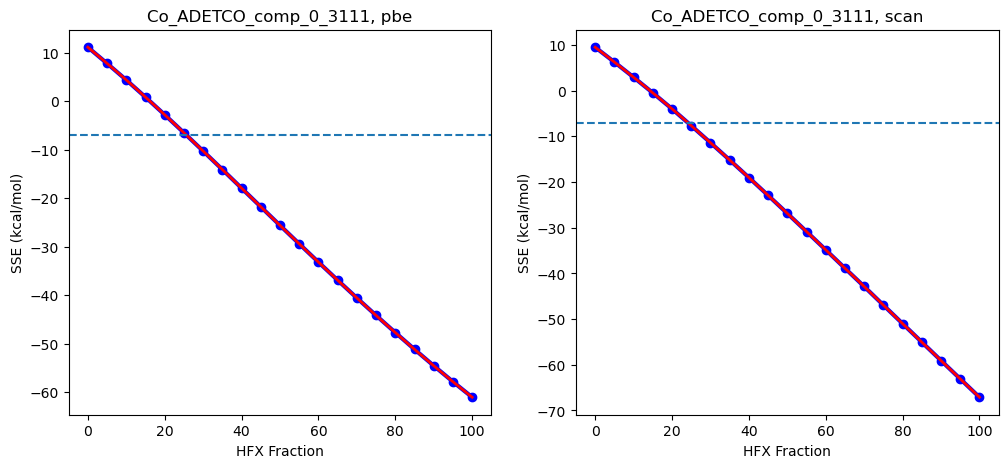

In [3]:
#to visualize what points will be removed in the first iteration

csd_76 = pd.read_csv('../data/CSD-76.csv')
csd_76 = csd_76.set_index(csd_76['name'])

def sse_vs_hfx(structure):
    df = csd_76
    reference = df.loc[structure]['dlpno-CCSD_T.vertsse']
    plt.figure()
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    for idx, functional in enumerate(['pbe', 'scan']):
        all_increments = np.arange(0, 101, 5)
        increments = []
        sses = []
        for i, increment in enumerate(all_increments):
            sse = sse_df.loc[structure][functional + '_hfx_' + str(increment)]
            if not np.isnan(sse):
                sses.append(sse)
                increments.append(increment)
        ax[idx].plot(increments, sses, '-o', label='True Values', linewidth=3, color='b')
        ax[idx].set_xlabel('HFX Fraction')
        ax[idx].set_ylabel('SSE (kcal/mol)')
        ax[idx].set_title(structure + ', ' + functional)
        if len(increments) < 2:
            print('Not enough converged values!')
            continue
        else:
            spline = CubicSpline(increments, sses, extrapolate=True)
            prange = np.arange(np.min(increments), np.max(increments)+1, 1)
            ax[idx].plot(prange, spline(prange), label='Spline', linewidth=2, color='#FF0000')
            for i in range(len(sses)):
                new_increments = increments[:i] + increments[i+1:]
                new_sses = sses[:i] + sses[i+1:]
                spline2 = CubicSpline(new_increments, new_sses, extrapolate=True)
                errors = np.abs(spline(prange) - spline2(prange))
                if np.max(errors) > 5:
                    ax[idx].plot(increments[i], sses[i], 'o', ms=10)
                    #print(f'{structure}, {functional} has a point removed.')
                    #ax[idx].plot(np.arange(0, 101, 1), spline2(np.arange(0, 101, 1)), label='Spline', linewidth=2, color='#00FF00', alpha=0.5)

        ax[idx].axhline(reference, linestyle='--', label='Reference')
        #plt.legend()

for struct in tqdm(csd_76.index.to_list()):
    if 'Cr' in struct:
        #filter out all Cr structures
        continue
    sse_vs_hfx(struct)
    break

In [4]:
cleaned_sse_df = sse_df

pbe_num_removed_tot = 0
scan_num_removed_tot = 0
pbe_num_struct_removed = 0
scan_num_struct_removed = 0
num_removed = 1
iteration = 0

while num_removed > 0:
    pbe_num_removed = 0
    scan_num_removed = 0
    for structure in cleaned_sse_df.index:
        pbe_struct_removed = False
        scan_struct_removed = False
        for idx, functional in enumerate(['pbe', 'scan']):
            all_increments = np.arange(0, 101, 5)
            increments = []
            sses = []
            for i, increment in enumerate(all_increments):
                sse = cleaned_sse_df.loc[structure][functional + '_hfx_' + str(increment)]
                if not np.isnan(sse):
                    sses.append(sse)
                    increments.append(increment)
            if len(increments) <= 2:
                pass
                #print('Not enough converged values!')
            else:
                spline = CubicSpline(increments, sses, extrapolate=True)
                prange = np.arange(np.min(increments), np.max(increments)+1, 1)
                for i in range(len(sses)):
                    new_increments = increments[:i] + increments[i+1:]
                    new_sses = sses[:i] + sses[i+1:]
                    spline2 = CubicSpline(new_increments, new_sses, extrapolate=True)
                    errors = np.abs(spline(prange) - spline2(prange))
                    if np.max(errors) > 5 and not np.isnan(cleaned_sse_df[functional + '_hfx_' + str(increments[i])][structure]):
                        if functional == 'pbe':
                            pbe_num_removed += 1
                        else:
                            scan_num_removed += 1
                        cleaned_sse_df[functional + '_hfx_' + str(increments[i])][structure] = np.nan
                        if not pbe_struct_removed and functional == 'pbe':
                            pbe_struct_removed = True
                        if not scan_struct_removed and functional == 'scan':
                            scan_struct_removed = True
        pbe_num_struct_removed += pbe_struct_removed
        scan_num_struct_removed += scan_struct_removed
    num_removed = pbe_num_removed + scan_num_removed
    iteration +=1
    print(f'The number of removed calculations for PBE in iteration {iteration} is {pbe_num_removed}.')
    print(f'The number of removed calculations for SCAN in iteration {iteration} is {scan_num_removed}.')
    pbe_num_removed_tot += pbe_num_removed
    scan_num_removed_tot += scan_num_removed

print(f'The total number of removed calculations for PBE is {pbe_num_removed_tot}.')
print(f'The total number of removed calculations for SCAN is {scan_num_removed_tot}.')
print(f'The number of structures that had at least one calculation removed for PBE is {pbe_num_struct_removed}.')
print(f'The number of structures that had at least one calculation removed for SCAN is {scan_num_struct_removed}.')

num_omitted_pbe = 0
num_omitted_scan = 0
for idx, row in cleaned_sse_df.iterrows():
    pbe_vals = [row[key] for key in row.keys() if key.startswith('pbe')]
    scan_vals = [row[key] for key in row.keys() if key.startswith('scan')]
    if len(pbe_vals) - sum([np.isnan(x) for x in pbe_vals]) < 5:
        print(f'Structure {row.name} was removed for functional PBE.')
        num_omitted_pbe += 1
    if len(scan_vals) - sum([np.isnan(x) for x in scan_vals]) < 5:
        print(f'Structure {row.name} was removed for functional SCAN.')
        num_omitted_scan += 1

print(f'The number of omitted structures for PBE is {num_omitted_pbe}.')
print(f'The number of omitted structures for SCAN is {num_omitted_scan}.')

cleaned_sse_df.to_csv('../data/cleaned_csd76_sse.csv')

The number of removed calculations for PBE in iteration 1 is 34.
The number of removed calculations for SCAN in iteration 1 is 50.
The number of removed calculations for PBE in iteration 2 is 5.
The number of removed calculations for SCAN in iteration 2 is 4.
The number of removed calculations for PBE in iteration 3 is 0.
The number of removed calculations for SCAN in iteration 3 is 3.
The number of removed calculations for PBE in iteration 4 is 0.
The number of removed calculations for SCAN in iteration 4 is 0.
The total number of removed calculations for PBE is 39.
The total number of removed calculations for SCAN is 57.
The number of structures that had at least one calculation removed for PBE is 11.
The number of structures that had at least one calculation removed for SCAN is 12.
Structure Mn_VUMSON_comp_0_111111 was removed for functional PBE.
Structure Mn_VUMSON_comp_0_111111 was removed for functional SCAN.
Structure Fe_GESJOG_comp_0_3111 was removed for functional SCAN.
Struct

# Filtering VSS-452

In [5]:
output_df = pd.read_csv('../data/raw_vss452_outputs.csv')
output_df = output_df.set_index('Unnamed: 0')

complexes = list(set([structure.rsplit('_', 1)[0] for structure in output_df.index]))
functionals = list(output_df.columns)

sse_df = pd.DataFrame(index=complexes, columns=functionals)

for structure, row in sse_df.iterrows():
    for functional in functionals:
        HSE = output_df[functional][structure + '_HS']
        LSE = output_df[functional][structure + '_LS']
        sse_df.loc[structure][functional] = (HSE-LSE)*627.509 #Ha to kcal/mol

sse_df

,pbe_hfx_0,pbe_hfx_10,pbe_hfx_100,pbe_hfx_15,pbe_hfx_20,pbe_hfx_25,pbe_hfx_30,pbe_hfx_35,pbe_hfx_40,pbe_hfx_45,...,scan_hfx_50,scan_hfx_55,scan_hfx_60,scan_hfx_65,scan_hfx_70,scan_hfx_75,scan_hfx_80,scan_hfx_85,scan_hfx_90,scan_hfx_95
mn/2/mn_2_ammonia-N-0-0_ammonia-N-0-0_ammonia-N-0-0_formaldehyde-O-1-0_ammonia-N-0-0_formaldehyde-O-1-0_6,-53.374874,-62.297444,-109.707995,-66.191634,-69.869494,-73.288183,-76.507285,-79.526834,-82.506667,-85.315852,...,-91.197699,-93.762437,-95.977839,-98.171423,-100.328746,-102.443774,-104.509575,-106.503533,-108.409535,-110.344859
fe/2/other/fe_2_ome2-O-0-0_ome2-O-0-0_ome2-O-0-0_ome2-O-0-0_ome2-O-0-0_formaldehyde-O-1-0_5,-44.780623,-50.898864,-85.819146,-53.76527,-56.492549,-59.083359,-61.534645,-63.815827,-66.070793,-68.137385,...,-68.363301,-71.102148,-73.800902,-76.460031,-79.084988,-81.676823,-84.239676,-86.774935,-89.285644,-91.773276
fe/2/a_f/fe_2_acetonitrile-N-1-0_acetonitrile-N-1-0_acetonitrile-N-1-0_acetonitrile-N-1-0_water-O-0-0_water-O-0-0_5,-25.262799,-33.289298,-73.654024,-36.865913,-40.188085,-43.280454,-46.166211,-48.899484,-51.376146,-53.803973,...,-54.734507,-57.62182,-60.461011,-63.247694,-65.993692,-68.696993,-71.365323,-73.998619,-76.601786,-79.17588
fe/2/other/fe_2_chloride-Cl-0-d1_chloride-Cl-0-d1_chloride-Cl-0-d1_misc-C-4-0_misc-C-4-0_misc-C-4-0_5,-18.949498,-28.721326,67.323793,-33.116859,NaN,-41.010813,-44.482394,-47.785272,NaN,-47.509048,...,NaN,-58.387135,-61.467214,NaN,-67.270415,-70.000119,-72.755446,-75.544325,-77.995701,NaN
mn/2/mn_2_imidazole-N-2-0_imidazole-N-2-0_imidazole-N-2-0_pyridine-N-3-0_pyridine-N-3-0_pyridine-N-3-0_6,NaN,-56.004205,NaN,NaN,NaN,-69.056711,-72.447817,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
co/2/co_2_phosphine-P-0-0_phosphine-P-0-0_phosphine-P-0-0_phosphine-P-0-0_formaldehyde-O-1-0_formaldehyde-O-1-0_4,-0.936385,-7.91004,-51.825526,-11.351585,-14.910189,-18.192197,-21.674281,-24.888477,-27.957324,-30.834467,...,-34.908296,-37.345395,-39.657203,-41.848362,-43.855089,-46.125019,-48.110076,-50.011746,-51.83937,-53.579142
co/3/co_3_phosphine-P-0-0_phosphine-P-0-0_phosphine-P-0-0_phosphine-P-0-0_phosphine-P-0-0_formaldehyde-O-1-0_5,19.003713,NaN,-68.808442,7.794197,NaN,NaN,-11.506987,-10.692371,NaN,-20.357469,...,-27.15494,-31.68945,-36.197765,-49.674165,-54.167703,-58.448401,-62.615827,-66.667076,-70.716436,-74.598767
mn/3/mn_3_furan-O-0-0_furan-O-0-0_furan-O-0-0_furan-O-0-0_hydroxyl-O-0-d1_hydroxyl-O-0-d1_5,NaN,-72.154616,-112.53794,-75.3565,-78.522626,-81.553137,-84.473785,-87.274466,-89.949084,-92.492633,...,-95.965052,-160.924401,-162.181419,-101.939018,-164.615292,-165.721459,-166.853907,-168.023232,-110.498726,-112.000931
co/2/co_2_phosphine-P-0-0_phosphine-P-0-0_phosphine-P-0-0_phosphine-P-0-0_phosphine-P-0-0_imidazole-N-2-0_4,-0.265924,-7.331711,-48.742057,-10.907019,-14.240745,-17.580173,-20.690334,-23.620563,-26.404998,-28.963648,...,-32.236037,-34.489974,-36.780736,-38.803276,-41.065492,-43.059618,-44.980706,-46.837465,-48.625811,-50.34149


0
mn/2/mn_2_ammonia-N-0-0_ammonia-N-0-0_ammonia-N-0-0_formaldehyde-O-1-0_ammonia-N-0-0_formaldehyde-O-1-0_6


<Figure size 640x480 with 0 Axes>

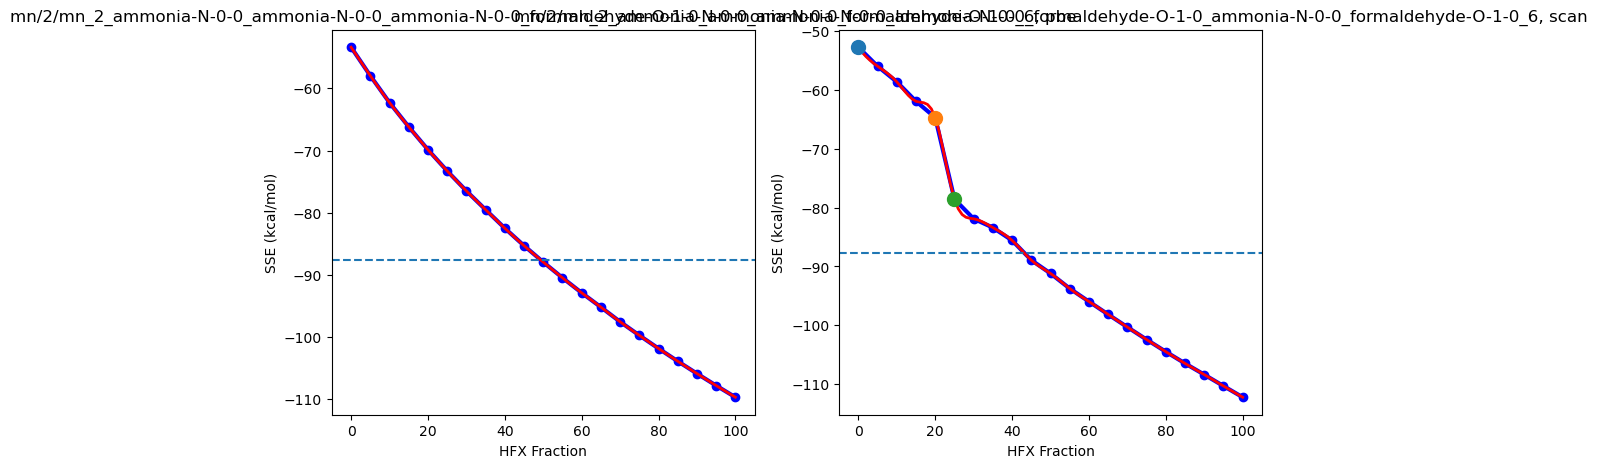

In [6]:
#to visualize what points will be removed in the first iteration

vss_452 = pd.read_csv('../data/VSS-452.csv')
vss_452 = vss_452.set_index(vss_452['name'])

def sse_vs_hfx(structure):
    df = vss_452
    reference = df.loc[structure.split('/')[-1]]['dlpno-CCSD_T.vertsse']
    plt.figure()
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    for idx, functional in enumerate(['pbe', 'scan']):
        all_increments = np.arange(0, 101, 5)
        increments = []
        sses = []
        for i, increment in enumerate(all_increments):
            sse = sse_df.loc[structure][functional + '_hfx_' + str(increment)]
            if not np.isnan(sse):
                sses.append(sse)
                increments.append(increment)
        ax[idx].plot(increments, sses, '-o', label='True Values', linewidth=3, color='b')
        ax[idx].set_xlabel('HFX Fraction')
        ax[idx].set_ylabel('SSE (kcal/mol)')
        ax[idx].set_title(structure + ', ' + functional)
        if len(increments) < 5:
            print('Not enough converged values!')
            continue
        else:
            spline = CubicSpline(increments, sses, extrapolate=True)
            prange = np.arange(np.min(increments), np.max(increments)+1, 1)
            ax[idx].plot(prange, spline(prange), label='Spline', linewidth=2, color='#FF0000')
            for i in range(len(sses)):
                new_increments = increments[:i] + increments[i+1:]
                new_sses = sses[:i] + sses[i+1:]
                spline2 = CubicSpline(new_increments, new_sses, extrapolate=True)
                errors = np.abs(spline(prange) - spline2(prange))
                if np.max(errors) > 5:
                    ax[idx].plot(increments[i], sses[i], 'o', ms=10)
                    #print(f'{structure}, {functional} has a point removed.')
                    #ax[idx].plot(np.arange(0, 101, 1), spline2(np.arange(0, 101, 1)), label='Spline', linewidth=2, color='#00FF00', alpha=0.5)

        ax[idx].axhline(reference, linestyle='--', label='Reference')
        #plt.legend()

structs = sse_df.index.to_list()
i = 0

#Iterate through here to see all structures
print(i)
print(structs[i])
sse_vs_hfx(structs[i])
i += 1

In [7]:
cleaned_sse_df = sse_df

pbe_num_removed_tot = 0
scan_num_removed_tot = 0
pbe_num_struct_removed = 0
scan_num_struct_removed = 0
num_removed = 1
iteration = 0

while num_removed > 0:
    pbe_num_removed = 0
    scan_num_removed = 0
    for structure in cleaned_sse_df.index:
        pbe_struct_removed = False
        scan_struct_removed = False
        for idx, functional in enumerate(['pbe', 'scan']):
            all_increments = np.arange(0, 101, 5)
            increments = []
            sses = []
            for i, increment in enumerate(all_increments):
                sse = cleaned_sse_df.loc[structure][functional + '_hfx_' + str(increment)]
                if not np.isnan(sse):
                    sses.append(sse)
                    increments.append(increment)
            if len(increments) <= 2:
                pass
                #print('Not enough converged values!')
            else:
                spline = CubicSpline(increments, sses, extrapolate=True)
                prange = np.arange(np.min(increments), np.max(increments)+1, 1)
                for i in range(len(sses)):
                    new_increments = increments[:i] + increments[i+1:]
                    new_sses = sses[:i] + sses[i+1:]
                    spline2 = CubicSpline(new_increments, new_sses, extrapolate=True)
                    errors = np.abs(spline(prange) - spline2(prange))
                    if np.max(errors) > 5 and not np.isnan(cleaned_sse_df[functional + '_hfx_' + str(increments[i])][structure]):
                        if functional == 'pbe':
                            pbe_num_removed += 1
                        else:
                            scan_num_removed += 1
                        cleaned_sse_df[functional + '_hfx_' + str(increments[i])][structure] = np.nan
                        if not pbe_struct_removed and functional == 'pbe':
                            pbe_struct_removed = True
                        if not scan_struct_removed and functional == 'scan':
                            scan_struct_removed = True
        pbe_num_struct_removed += pbe_struct_removed
        scan_num_struct_removed += scan_struct_removed
    num_removed = pbe_num_removed + scan_num_removed
    iteration +=1
    print(f'The number of removed calculations for PBE in iteration {iteration} is {pbe_num_removed}.')
    print(f'The number of removed calculations for SCAN in iteration {iteration} is {scan_num_removed}.')
    pbe_num_removed_tot += pbe_num_removed
    scan_num_removed_tot += scan_num_removed

print(f'The total number of removed calculations for PBE is {pbe_num_removed_tot}.')
print(f'The total number of removed calculations for SCAN is {scan_num_removed_tot}.')
print(f'The number of structures that had at least one calculation removed for PBE is {pbe_num_struct_removed}.')
print(f'The number of structures that had at least one calculation removed for PBE is {scan_num_struct_removed}.')

num_omitted_pbe = 0
num_omitted_scan = 0
for idx, row in cleaned_sse_df.iterrows():
    pbe_vals = [row[key] for key in row.keys() if key.startswith('pbe')]
    scan_vals = [row[key] for key in row.keys() if key.startswith('scan')]
    if len(pbe_vals) - sum([np.isnan(x) for x in pbe_vals]) < 5:
        #print(f'Structure {row.name} was removed for functional PBE.')
        num_omitted_pbe += 1
    if len(scan_vals) - sum([np.isnan(x) for x in scan_vals]) < 5:
        #print(f'Structure {row.name} was removed for functional SCAN.')
        num_omitted_scan += 1

print(f'The number of omitted structures for PBE is {num_omitted_pbe}.')
print(f'The number of omitted structures for SCAN is {num_omitted_scan}.')

cleaned_sse_df.to_csv('../data/cleaned_vss452_sse.csv')

The number of removed calculations for PBE in iteration 1 is 474.
The number of removed calculations for SCAN in iteration 1 is 647.
The number of removed calculations for PBE in iteration 2 is 39.
The number of removed calculations for SCAN in iteration 2 is 94.
The number of removed calculations for PBE in iteration 3 is 11.
The number of removed calculations for SCAN in iteration 3 is 30.
The number of removed calculations for PBE in iteration 4 is 3.
The number of removed calculations for SCAN in iteration 4 is 12.
The number of removed calculations for PBE in iteration 5 is 2.
The number of removed calculations for SCAN in iteration 5 is 3.
The number of removed calculations for PBE in iteration 6 is 1.
The number of removed calculations for SCAN in iteration 6 is 1.
The number of removed calculations for PBE in iteration 7 is 0.
The number of removed calculations for SCAN in iteration 7 is 1.
The number of removed calculations for PBE in iteration 8 is 0.
The number of removed ca